In [ ]:
!pip install catboost
!pip install scikit-learn

In [ ]:
from sklearn.neighbors import RadiusNeighborsRegressor
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 

float_features = ('rooms', 'floor')
categorical_columns = ('city', 'location')
required_columns = ('price', 'total_square', 'lat', 'lon')

In [68]:
df = pd.read_csv('data/realty_data.csv').dropna(subset = required_columns)

def preprocess(df):
    df['m2_price'] = df.price/df.total_square
    df['lat'] = np.radians(df['lat'])
    df['lon'] = np.radians(df['lon'])
    df['location'] = df['settlement'].combine_first(df['district'])
    df['location'] = df['location'].combine_first(df['area'])
    return df

df = preprocess(df)
df.head(1)

,product_name,period,price,postcode,address_name,lat,lon,object_type,total_square,rooms,floor,city,settlement,district,area,description,source,m2_price,location
0,"3-комнатная, 137 м²",NaN,63000000,127473.0,"2-й Щемиловский переулок, 5а",0.973525,0.656398,Квартира,137.0,3.0,6.0,Москва,NaN,Тверской район,NaN,Просторная квартира свободной планировки с пан...,ЦИАН,459854.014599,Тверской район


In [ ]:
# пайплайны обработки

class AggCalculator(BaseEstimator, TransformerMixin):
    '''
    агрегации цены м2 по
    '''
    def __init__(self):
        self.model = RadiusNeighborsRegressor(
            algorithm = 'ball_tree', 
            radius=0.5 / 6371, 
            metric='haversine', 
            n_jobs = 20)

    def __calc_aggs(self, X):
        '''
        считаем агрегаты цены 1м2 в окрестности радиуса r
        '''
        res = dict()
        for radius in (0.1, 0.5):
            res[f"mean_{radius}"] = []
            res[f"max_{radius}"] = []
            res[f"min_{radius}"] = []

            indices = self.model.radius_neighbors(X, radius = radius/ 6371, return_distance=False)
            for i in range(len(indices)):
                valid_inds = indices[i]
                if len(valid_inds) > 0:
                    y_neigb = self.target_vals[valid_inds]
                    res[f"mean_{radius}"].append(y_neigb.mean())
                    res[f"max_{radius}"].append(y_neigb.max())
                    res[f"min_{radius}"].append(y_neigb.min())
                else:
                    res[f"mean_{radius}"].append(self.mean)
                    res[f"max_{radius}"].append(self.min)
                    res[f"min_{radius}"].append(self.max)
        return pd.DataFrame({k:np.array(v) for k,v in res.items()})

    def fit(self, X, y=None):
        self.target_vals = y.values.copy()
        self.mean = X['m2_price'].mean()
        self.min = X['m2_price'].min()
        self.max = X['m2_price'].max()

        self.model.fit(X[['lat', 'lon']], y)

        return self
    
    def set_output(self, transform="pandas"):
        pass
        

    def transform(self, X, y=None):
        return np.log1p(self.__calc_aggs(X[['lat', 'lon']])) \
            + np.log1p(X.total_square.values).reshape(-1,1)
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        res = np.log1p(self.__calc_aggs(None))
        return res + np.log1p(X.total_square.values).reshape(-1,1)

pr_stage1 = ColumnTransformer(
    transformers=[
        (
            "fnan",
            SimpleImputer(strategy="constant", fill_value=0),
            float_features,
        ),
        (
            "ord",
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-2, encoded_missing_value=-1),
            categorical_columns
        ),
        (
            "agg",
            AggCalculator(),
            ['lat', 'lon','m2_price','total_square']
        ),
    ],
)

pr_stage2 = ColumnTransformer(
    remainder='passthrough',verbose_feature_names_out = False,
    transformers=[
        ('normalize', FunctionTransformer(lambda x: x.astype(int)), ['ord__city', 'ord__location']),
    ])

pr_stage1.set_output(transform='pandas')
pr_stage2.set_output(transform='pandas')

pipeline = Pipeline([("stage1", pr_stage1), ("stage2", pr_stage2)])

In [109]:
X_train, X_test, Y_train, Y_test = train_test_split( 
    df.drop(columns=['price']), df.price, random_state=0, test_size=0.2) 

In [110]:
X_train_feat = pipeline.fit_transform(X_train.reset_index(), Y_train.reset_index())

In [124]:
model = TransformedTargetRegressor(
    CatBoostRegressor(cat_features = ('ord__city', 'ord__location')), func=np.log1p, inverse_func=np.expm1
)
model.fit(X_train_feat, Y_train)

Learning rate set to 0.081668
0:	learn: 0.7046153	total: 46.8ms	remaining: 46.7s
1:	learn: 0.6557709	total: 95.3ms	remaining: 47.6s
2:	learn: 0.6110213	total: 145ms	remaining: 48.1s
3:	learn: 0.5697485	total: 187ms	remaining: 46.7s
4:	learn: 0.5326838	total: 238ms	remaining: 47.4s
5:	learn: 0.4984999	total: 285ms	remaining: 47.1s
6:	learn: 0.4670561	total: 327ms	remaining: 46.4s
7:	learn: 0.4387218	total: 369ms	remaining: 45.7s
8:	learn: 0.4130290	total: 410ms	remaining: 45.2s
9:	learn: 0.3898799	total: 455ms	remaining: 45s
10:	learn: 0.3684138	total: 503ms	remaining: 45.2s
11:	learn: 0.3491410	total: 546ms	remaining: 45s
12:	learn: 0.3319197	total: 591ms	remaining: 44.9s
13:	learn: 0.3160203	total: 632ms	remaining: 44.5s
14:	learn: 0.3017623	total: 684ms	remaining: 44.9s
15:	learn: 0.2885036	total: 734ms	remaining: 45.2s
16:	learn: 0.2769101	total: 781ms	remaining: 45.2s
17:	learn: 0.2662900	total: 825ms	remaining: 45s
18:	learn: 0.2567817	total: 878ms	remaining: 45.3s
19:	learn: 0.24

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=<catboost.core.CatBoostRegressor object at 0x0000027C6704D660>)

In [135]:
X_test_feat = pipeline.transform(X_test.reset_index())
Y_pred = model.predict(X_test_feat)

# считаем MAPE
mean_absolute_percentage_error(Y_test, Y_pred)

0.10899719694747219

## Интерпретация модели

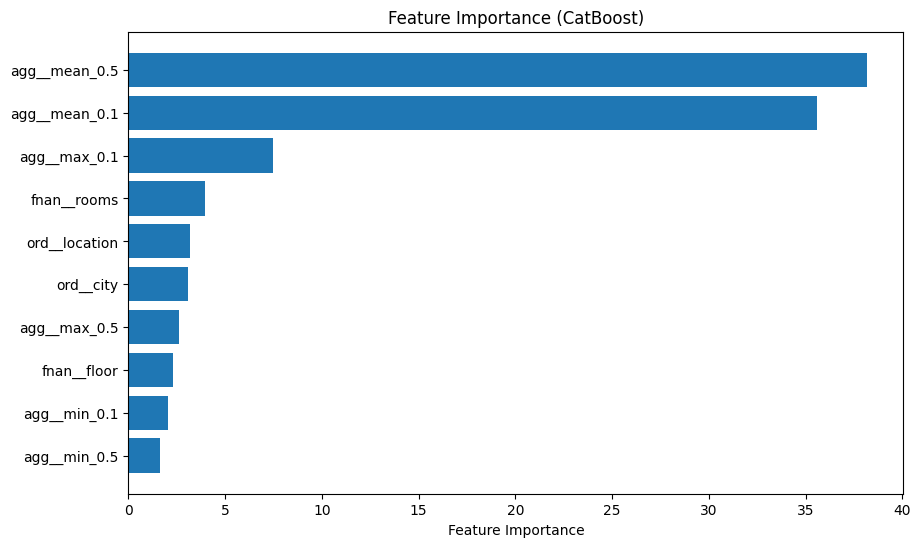

In [139]:
import matplotlib.pyplot as plt

# Важность признаков
feature_importance = model.regressor_.get_feature_importance()
feature_names = model.regressor_.feature_names_


# Сортировка признаков по важности
sorted_idx = np.argsort(feature_importance)
sorted_features = [feature_names[i] for i in sorted_idx]
sorted_importance = feature_importance[sorted_idx]

# Построение графика важности признаков
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_features)), sorted_importance, align='center')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlabel('Feature Importance')
plt.title('Feature Importance (CatBoost)')
plt.show()


In [ ]:
!pip install shap

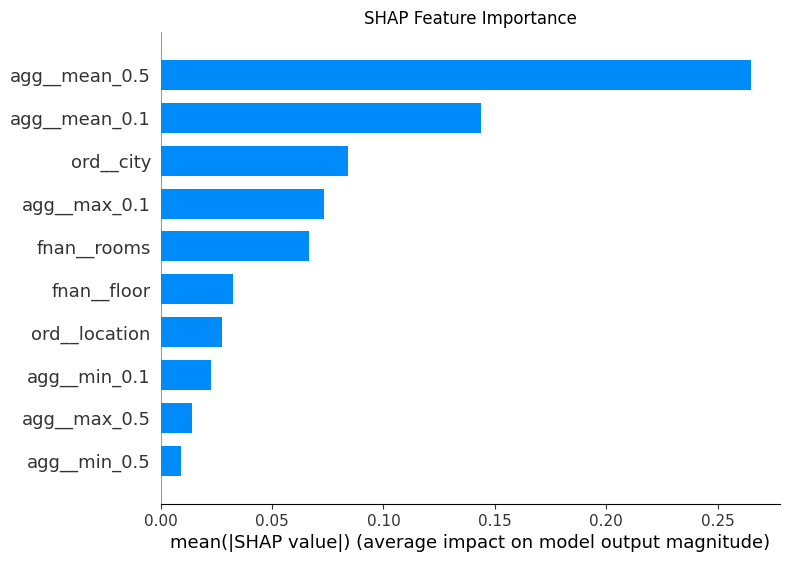

In [146]:
import shap
explainer = shap.TreeExplainer(model.regressor_)
shap_values = explainer.shap_values(X_test_feat)

# Визуализация SHAP-значений для всей модели
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_feat, plot_type="bar", show=False)
plt.title('SHAP Feature Importance')
plt.show()

### Выводы:

Как и предполагали ранее, наибольший вклад вносят усредненные по радиусу 500 и 100 м значения цены м2

## Дополнительно. Можно дополнить признаками из OpenStreetMap

In [ ]:
import requests
import json

overpass_url = "http://overpass-api.de/api/interpreter"
metro_query = """
[out:json][timeout:60];
area["name"="Москва"]->.moscow;
(
  node["railway"="station"]["station"="subway"](area.moscow);
);

out body;
>;
out skel qt;
"""

historic_query = """
[out:json][timeout:60];
area["name"="Москва"]->.moscow;
area["name"="Московская область"]->.mosobl;
(
  node["historic"](area.moscow);
  node["historic"](area.mosobl);
);
out body;
>;
out skel qt;
"""


In [ ]:
# метро 
response = requests.get(overpass_url, params={'data': metro_query})
data_metro = response.json()
with open('metro.json', 'w') as f:
    json.dump(data, f)

# исторические объекты
response = requests.get(overpass_url, params={'data': historic_query})
data_historic = response.json()
with open('historic.json', 'w') as f:
    json.dump(data_historic, f)

In [ ]:
# Можно рассчитать расстояние до метро и кол-во исторических объектов в окрестности

TBD